In [1]:
import sys
import pathlib

sys.path.insert(0, str(pathlib.Path().absolute().parent))

%load_ext autoreload
%autoreload 2

## Data Generation

In [2]:
import pandas as pd
import numpy as np
from CCIT import DataGen

In [3]:
dx = 1
dy = 5
dz = 1

size = 1000

gen_data = DataGen.generate_samples_cos(size=size, dx=dx, dy=dy, dz=dz, sType='NI')

y_hat       = gen_data[:,:dx]
y_true      = gen_data[:,dx+dy:dx+dy+dz]

z_protected = gen_data[:,dx:dx+dy]

dependent_z = z_protected[:,4:5].reshape(-1)
categorical_cond = [dependent_z < -0.5, dependent_z < 0, dependent_z < 0.5, dependent_z < 1]
categorical_values = [1, 2, 3, 4]

categorical_cond2 = [dependent_z < -0.25, dependent_z < -0.75, dependent_z < 0.75, dependent_z < 1]
categorical_values2 = ["cat1", "cat2", "cat3", "cat4"]

independent_var =  np.cos(1.0*(0.5*np.random.multivariate_normal(np.zeros(1),np.eye(1),size)))

data = pd.DataFrame({
    "protected_1" : z_protected[:,0:1].reshape(-1),
    "protected_2" : z_protected[:,1:2].reshape(-1),
    "protected_3" : z_protected[:,2:3].reshape(-1),
    "protected_4" : z_protected[:,3:4].reshape(-1),
    "protected_5" : z_protected[:,4:5].reshape(-1),
    "categorical" : np.select(categorical_cond, categorical_values),
    "categorical2": np.select(categorical_cond2, categorical_values2),
    "independent" : independent_var.reshape(-1),
    "y_true"      : y_true.reshape(-1),
    "y_hat"       : y_hat.reshape(-1)
})

In [4]:
data.head()

,protected_1,protected_2,protected_3,protected_4,protected_5,categorical,categorical2,independent,y_true,y_hat
0,-0.794211,-0.725681,-0.973310,-0.410993,-0.950000,1,cat1,0.937103,2.793849,0.333991
1,0.606602,0.215134,0.721918,0.793741,0.275575,3,cat3,0.728420,-0.875447,0.912905
2,-0.920376,-0.725224,-0.952432,-0.917203,-0.993941,1,cat1,0.880793,1.876065,0.658224
3,0.259566,0.490539,-0.945425,-0.250532,0.297092,3,cat3,0.965849,0.999582,0.375317
4,-0.308540,-0.427656,-0.716578,-0.723452,-0.343055,2,cat1,0.954474,0.524988,0.865787


## Package testing

### Testing

In [5]:
from model_bias.test.independence import demographic_parity, equalized_odds

#### Demographic Parity

In [6]:
demographic_parity(y_hat, z_protected)

0.014717305527501268

In [7]:
demographic_parity(
    "y_hat", 
    ["protected_1", "protected_2", "protected_3", "protected_4", "protected_5"], 
    data=data
)

0.014717305527501268

In [8]:
demographic_parity(
    "y_hat", 
    "independent", 
    data=data
)

0.3179657483809392

#### Equalized Odds

In [9]:
equalized_odds(y_hat, z_protected, y_true)

7.618983709836672e-05

In [10]:
equalized_odds(
    "y_hat", 
    ["protected_1", "protected_2", "protected_3", "protected_4", "protected_5"], 
    "y_true", 
    data=data
)

7.618983709836672e-05

In [11]:
equalized_odds(
    "y_hat", 
    "independent", 
    "y_true", 
    data=data
)

0.5

### Visualisation

#### Scatter

In [13]:
from model_bias.visualisation.plot import scatter

In [14]:
scatter("protected_1", "protected_2", "categorical", data=data)

GridBox(id='1108', ...)

#### Distribution

In [15]:
from model_bias.visualisation.plot import distribution

In [16]:
distribution("protected_3", data=data)

Figure(id='1322', ...)

#### Boxplot

In [17]:
from model_bias.visualisation.plot import boxplot

In [18]:
boxplot("protected_3", data=data)

Figure(id='1463', ...)

In [19]:
boxplot(data["protected_3"], data[["categorical"]])

Figure(id='1675', ...)

#### Frequencies

In [20]:
from model_bias.visualisation.plot import counts

In [21]:
counts("categorical", data=data)

Figure(id='1922', ...)

In [22]:
counts("categorical", "categorical2", data=data)

Figure(id='2080', ...)

## Explainability

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       152
        True       1.00      1.00      1.00       848

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



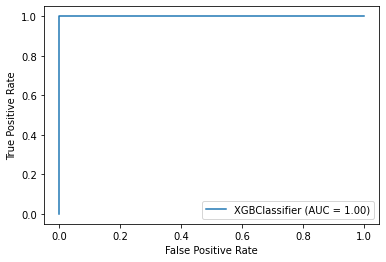

In [23]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

model = XGBClassifier()

y = data["y_true"] > 0
X = data[
    ["protected_1", "protected_2", "protected_3", "protected_4", "protected_5", 
     "categorical", "categorical2", "independent"]
]
X = pd.get_dummies(X)

model.fit(X, y)

y_hat = model.predict(X)
y_proba = pd.DataFrame(model.predict_proba(X)[:,1], index=X.index)

print(classification_report(y, y_hat))

plot_roc_curve(model, X, y)

In [24]:
from model_bias.visualisation.explainability import features_importance
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

features_importance(shap_values, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


invalid value encountered in true_divide
invalid value encountered in true_divide


Figure(id='2244', ...)

In [25]:
from model_bias.visualisation.explainability import feature_importance_dependence

X_new = X.copy()
categorical2_columns = X.filter(like="categorical2_", axis=1).columns
all_cat2_idxs = [list(X_new.columns).index(c) for c in categorical2_columns]
cat_column = X_new[categorical2_columns].idxmax(axis=1)
col_idxs = [list(X_new.columns).index(c) for c in cat_column]
shap_values_agg = np.array([shap_values[i,j] for i, j in enumerate(col_idxs)]).reshape(-1, 1)
X_new["categorical2"] = cat_column.str.split("_").apply(lambda x: x[1])
X_new = X_new.drop(columns=categorical2_columns)
shap_values_new = np.delete(shap_values, all_cat2_idxs, 1)
shap_values_new = np.concatenate((shap_values_new, shap_values_agg), 1)

feature_importance_dependence(shap_values_new, X_new, "protected_5", "categorical2")

GridBox(id='2532', ...)

In [26]:
feature_importance_dependence(shap_values_new, X_new, "categorical", "categorical2")

Figure(id='2844', ...)

In [27]:
feature_importance_dependence(shap_values, X, "independent")

GridBox(id='3248', ...)